# 20190108: Pulling out synonymous WT mutants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
my_store = pd.HDFStore('2017.07.24_Radicicol_exp.h5')
myStoreKeys = my_store.keys()

variantScores = my_store.select('/main/variants/scores')

In [3]:
# Keep only rows with WT sequences 
idx = variantScores.index.tolist()
idx = ['(p.=)' in name for name in idx]

variantScores = variantScores[idx]

idx = variantScores.index.tolist()
wtMuts = [name.count('(p.=)') for name in idx]
otherMuts = [name.count('(p.') for name in idx]
wtMutsOnly = []
for idMuts, muts in zip(wtMuts, otherMuts):
    wtMutsOnly.append(idMuts == muts)
    
variantScores = variantScores[wtMutsOnly]

In [4]:
# Remove nans from score arrays
varRad = variantScores.loc[:, ('Radicicol', 'score')].values
varRad = varRad[~np.isnan(varRad)]

varZero = variantScores.loc[:, ('Zero', 'score')].values
varZero = varZero[~np.isnan(varZero)]

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


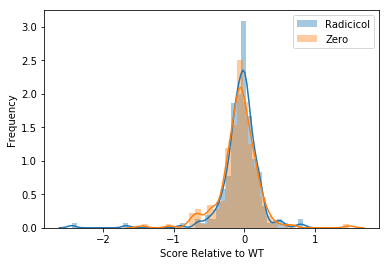

In [5]:
# Plot distributions
sns.distplot(varRad, label = 'Radicicol')
sns.distplot(varZero, label = 'Zero')
plt.xlabel('Score Relative to WT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 20190109: Function for pulling out synonymous WT mutants

In [6]:
def getSynMuts(df):
    idx = df.index.tolist()
    idx = ['(p.=)' in name for name in idx]
    df = df[idx]
    idx = df.index.tolist()
    wtMuts = [name.count('(p.=)') for name in idx]
    otherMuts = [name.count('(p.') for name in idx]
    wtMutsOnly = []
    for idMuts, muts in zip(wtMuts, otherMuts):
        wtMutsOnly.append(idMuts == muts)
    return(df[wtMutsOnly])

In [7]:
def getSynMuts2(df):
    """
    Takes a DataFrame with codon and protein mutations in as the index and returns a DataFrame 
    with only the wild type synonymous mutants, mutants that have protein sequence identity to 
    that of the wild type.
    """
    idx = df.index.tolist()
    wtMuts = [name.count('(p.=)') for name in idx]
    otherMuts = [name.count('(p.') for name in idx]
    wtMutsOnly = []
    for idMuts, muts in zip(wtMuts, otherMuts):
        wtMutsOnly.append(idMuts == muts)
    return(df[wtMutsOnly])

# Getting standard deviation to threshold variants

In [8]:
# Define standard deviations for radicicol and control treatments for synonymous mutants and load synonymous data
sdRad = np.std(varRad)    # 0.2926579180309401
sdZero = np.std(varZero)  # 0.28323869489237435

srcBothReps = pd.read_csv('main_synonymous_both_reps.csv', index_col = 0)

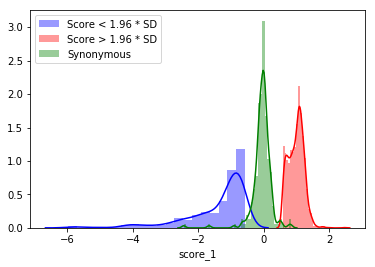

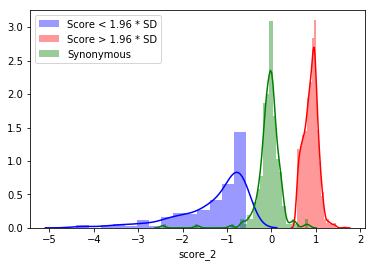

In [9]:
i = 1
thresh = 1.96 * sdRad
for score in ['score_1', 'score_2']:
    plt.figure(i)
    scores = srcBothReps[score].dropna()
    negScore = scores[(scores < -thresh)]
    posScore = scores[(scores > thresh)]
    sns.distplot(negScore, color = 'b', label = "Score < 1.96 * SD")
    sns.distplot(posScore, color = 'r', label = 'Score > 1.96 * SD')
    sns.distplot(varRad, color = 'g', label = 'Synonymous')
    plt.legend()
    plt.ylim(0, 3.25)
    plt.show()
    i += 1

# Using main scores and getting summary statistics

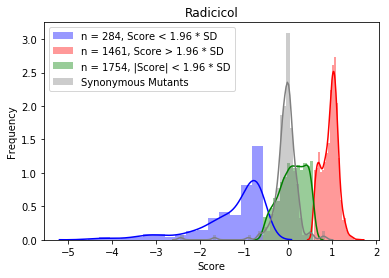

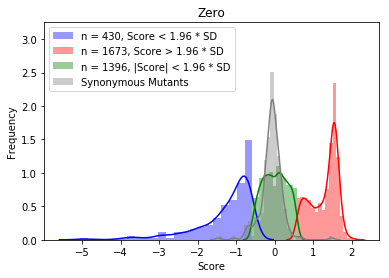

In [10]:
pointMuts = my_store.select('/main/synonymous/scores')[2:]    # Dropped _sy and _wt (what is _sy?)
idx = [',' not in name for name in pointMuts.index.tolist()] 
pointMuts = pointMuts[idx]
pointMuts = pointMuts[pointMuts['Radicicol', 'score'].notna() & pointMuts['Zero', 'score'].notna()]
i = 1
for treatment, syn in zip(['Radicicol', 'Zero'], [varRad, varZero]):
    plt.figure(i)
    scores = pointMuts[treatment, 'score'].dropna()
    negScore = scores[(scores < -thresh)]
    posScore = scores[(scores > thresh)]
    wtScore = scores[((scores > -thresh) & (scores < thresh))]
    sns.distplot(negScore, color = 'b', label = ('n = %d, Score < 1.96 * SD' %len(negScore)))
    sns.distplot(posScore, color = 'r', label = ('n = %d, Score > 1.96 * SD' %len(posScore)))
    sns.distplot(wtScore, color = 'g', label = ('n = %d, |Score| < 1.96 * SD' %len(wtScore)))
    sns.distplot(syn, color = 'grey', label = 'Synonymous Mutants')
    plt.legend()
    plt.ylim(0, 3.25)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(treatment)
    plt.show()
    i += 1

# 20190110: Getting full distribution shapes and figuring out radicicol sensitivity metric

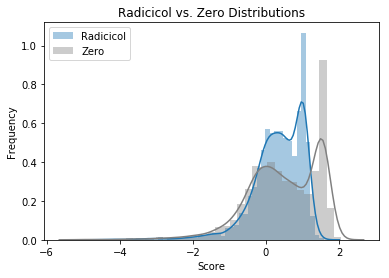

In [11]:
# Distribution of radicicol and zero treatments for point mutants
sns.distplot(pointMuts['Radicicol', 'score'], label = 'Radicicol')
sns.distplot(pointMuts['Zero', 'score'], label = 'Zero', color = 'gray')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Radicicol vs. Zero Distributions')
plt.show()

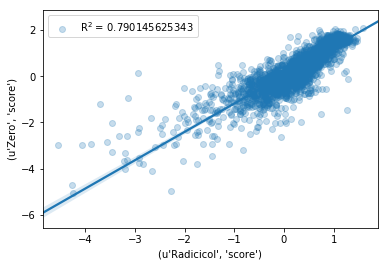

In [12]:
# Probing for radicicol sensitivity metric
radPointMuts = pointMuts['Radicicol', 'score']
zerPointMuts = pointMuts['Zero', 'score']
r = np.corrcoef(radPointMuts, zerPointMuts)
rsq = r[0,1]**2
sns.regplot(radPointMuts, zerPointMuts, scatter_kws = {'alpha':0.25}, label = "R$^2$ = "+ str(rsq))
plt.legend()
plt.show()

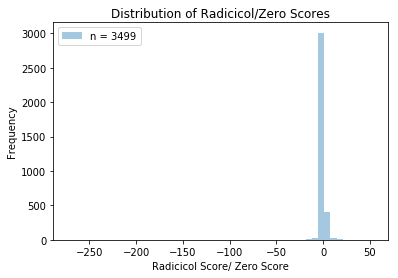

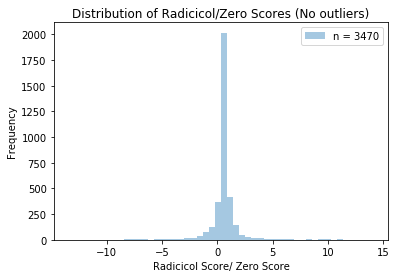

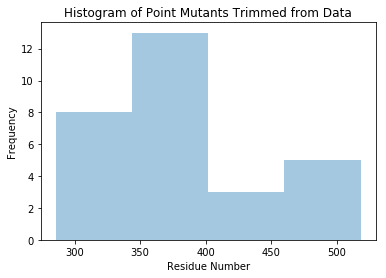

In [13]:
# Looking at the distribution of the ratio Radicicol/Zero
ratios = radPointMuts / zerPointMuts
sns.distplot(ratios, kde = False, label = 'n = %d' %len(ratios))
plt.xlabel('Radicicol Score/ Zero Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Radicicol/Zero Scores')
plt.show()

thresh = np.std(ratios) * 1.96

lowRatios = ratios[ratios < -thresh]
highRatios = ratios[ratios > thresh]

ratioTrim = ratios.drop(lowRatios.index.tolist())
ratioTrim = ratioTrim.drop(highRatios.index.tolist())
sns.distplot(ratioTrim, kde = False, label = 'n = %d' %len(ratioTrim))
plt.legend()
plt.xlabel('Radicicol Score/ Zero Score')
plt.ylabel('Frequency')
plt.title('Distribution of Radicicol/Zero Scores (No outliers)')
plt.show()

# Which mutations were trimmed from the data?
trimmedRatioMuts = set(ratios.index.tolist()) - set(ratioTrim.index.tolist())
sns.distplot([int(name[5:8]) for name in trimmedRatioMuts], kde = False)
plt.xlabel('Residue Number')
plt.ylabel('Frequency')
plt.title('Histogram of Point Mutants Trimmed from Data')
plt.show()

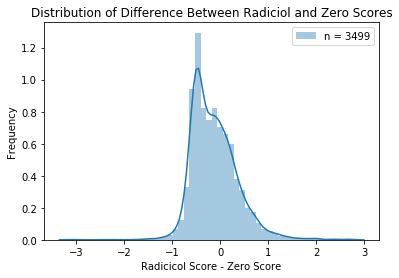

In [14]:
# Looking at differences between radicicol and zero scores
diffs = radPointMuts - zerPointMuts
sns.distplot(diffs, label = 'n = %d' %len(diffs))
plt.legend()
plt.title('Distribution of Difference Between Radiciol and Zero Scores')
plt.xlabel('Radicicol Score - Zero Score')
plt.ylabel('Frequency')
plt.show()

# 20191111: Radicicol sensitivity metric

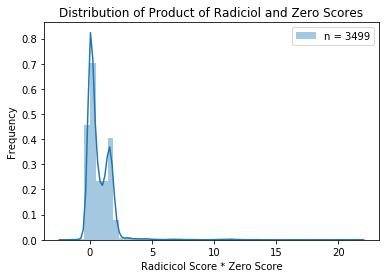

In [15]:
# Looking at product of radicicol and zero scores
prods = radPointMuts * zerPointMuts
sns.distplot(prods, label = 'n = %d' %len(diffs))
plt.legend()
plt.title('Distribution of Product of Radiciol and Zero Scores')
plt.xlabel('Radicicol Score * Zero Score')
plt.ylabel('Frequency')
plt.show()

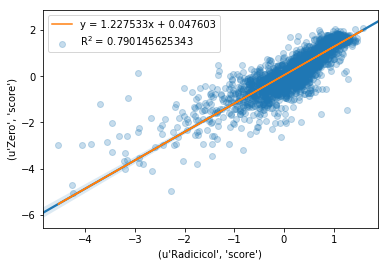

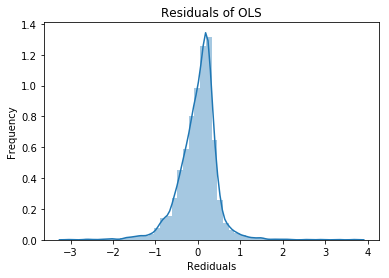

In [16]:
# Looking at residuals as a weighting metric
sns.regplot(radPointMuts, zerPointMuts, scatter_kws = {'alpha':0.25}, label = "R$^2$ = "+ str(rsq))
[m, b] = np.polyfit(radPointMuts, zerPointMuts, 1)
zerPointMutsHat = (b + m * radPointMuts)
plt.plot(radPointMuts, zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.legend()
plt.show()

resids = zerPointMuts - zerPointMutsHat
sns.distplot(resids, label = 'Residuals')
plt.xlabel('Rediduals')
plt.ylabel('Frequency')
plt.title('Residuals of OLS')
plt.show()

# 20190114: Transforming ratio distribution

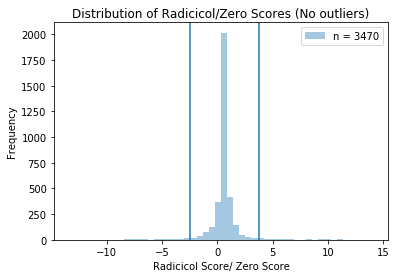

p.Ala370Gly    -31.875313
p.Ala370Ile   -271.999692
p.Arg271Lys     -4.198180
p.Arg294Ala     -8.909835
p.Arg294Thr    -21.583069
p.Arg422His     -4.535019
p.Arg422Lys     -4.478900
p.Arg422Pro     -4.499011
p.Arg441Gly     -6.296566
p.Arg441Val    -25.471420
p.Arg463Leu     -2.499224
p.Arg472Ser     -3.251204
p.Arg503Phe     -4.360363
p.Asn290Gln     -6.653267
p.Asn384Gln     -7.073718
p.Asn384Leu   -203.026148
p.Asn384Phe    -12.839860
p.Asn384Pro     -4.852629
p.Asn400Ile    -10.928815
p.Asp351Phe     -7.707708
p.Cys403Ile     -3.713002
p.Cys501Asn     -2.651354
p.Cys501Leu     -4.725846
p.Cys501Val    -37.356095
p.Gln278His     -4.581630
p.Gln372Ala     -2.626651
p.Gln372Gly     -2.611154
p.Gln500Ser     -3.657728
p.Glu308Cys     -2.498882
p.Glu308Lys     -2.504304
                  ...    
p.Phe512Ser      5.605859
p.Phe518Ile     20.194111
p.Pro302Ala      6.152329
p.Pro302Ile      4.537754
p.Pro302Lys      3.758887
p.Pro307Lys     13.193816
p.Pro434Glu     10.463554
p.Pro434Tyr 

In [17]:
# Use standard deviation as a general cutoff for ratio distribution(after large outliers have been removed)
ratioTrimSD = np.std(ratioTrim)
ratioTrimMean = np.mean(ratioTrim)
lowThresh = ratioTrimMean - 1.96 * ratioTrimSD
highThresh = ratioTrimMean + 1.96 * ratioTrimSD
sns.distplot(ratioTrim, kde = False, label = 'n = %d' %len(ratioTrim))
plt.axvline(lowThresh)
plt.axvline(highThresh)
plt.legend()
plt.xlabel('Radicicol Score/ Zero Score')
plt.ylabel('Frequency')
plt.title('Distribution of Radicicol/Zero Scores (No outliers)')
plt.show()

# Collect variants beyond this threshold
ratioVars = ratios[ratios < lowThresh]
ratioVars.append(ratios[ratios > highThresh])   # length = 188

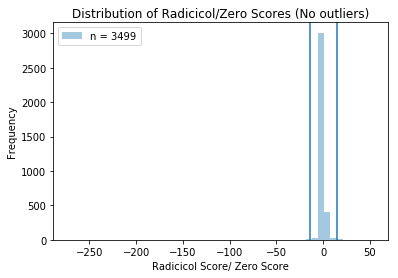

16

In [18]:
# Use standard deviation as a general cutoff for ratio distribution(BEFORE large outliers have been removed)
ratioSD = np.std(ratios)
ratioMean = np.mean(ratios)
lowThresh = ratioMean - 1.96 * ratioSD
highThresh = ratioMean + 1.96 * ratioSD
sns.distplot(ratios, kde = False, label = 'n = %d' %len(ratios))
plt.axvline(lowThresh)
plt.axvline(highThresh)
plt.legend()
plt.xlabel('Radicicol Score/ Zero Score')
plt.ylabel('Frequency')
plt.title('Distribution of Radicicol/Zero Scores (No outliers)')
plt.show()

# Collect variants beyond this threshold
ratioVars2 = ratios[ratios < lowThresh]
ratioVars2.append(ratios[ratios > highThresh])   # length 16
len(ratioVars2)

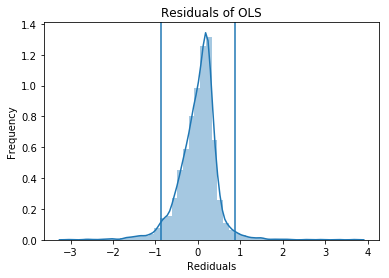

p.Ala330Gln   -1.350322
p.Ala330Trp   -0.922442
p.Ala374Cys   -1.012159
p.Ala378Asp   -0.891849
p.Ala378Tyr   -1.064683
p.Ala433Asp   -1.272810
p.Ala433Cys   -1.084006
p.Arg472Phe   -1.017838
p.Asn400Ile   -1.742965
p.Asp368Val   -0.882056
p.Asp447Glu   -1.297100
p.Asp476Val   -0.937655
p.Asp496Arg   -0.945859
p.Cys280His   -1.032458
p.Cys499Lys   -1.310558
p.Cys499Tyr   -1.119836
p.Cys501Asn   -1.122809
p.Gln372Lys   -1.846820
p.Gln477Phe   -1.090565
p.Gln516Pro   -0.949345
p.Glu273Gly   -0.889549
p.Glu273Ile   -2.015750
p.Glu323Arg   -1.195310
p.Glu323His   -1.169327
p.Glu323Lys   -1.131758
p.Glu323Thr   -0.928999
p.Glu334Cys   -1.146931
p.Glu334Phe   -0.940782
p.Glu381Arg   -2.242615
p.Glu381Leu   -2.437327
                 ...   
p.Lys275Gly    1.034757
p.Lys324Ser    1.083663
p.Met286Arg    0.889315
p.Met286Asp    1.015721
p.Met286Glu    1.063751
p.Met286Gly    1.256049
p.Met286Lys    1.322626
p.Met286Ser    0.886360
p.Pro428Tyr    0.971418
p.Thr292Ile    0.967786
p.Thr304Arg    1

In [19]:
# Using standard deviation as a general cutoff for residual distribution
residSD = np.std(resids)
residMean = np.mean(resids)
lowThresh = residMean - 1.96 * residSD
highThresh = residMean + 1.96 * residSD
sns.distplot(resids, label = 'Residuals')
plt.axvline(lowThresh)
plt.axvline(highThresh)
plt.xlabel('Rediduals')
plt.ylabel('Frequency')
plt.title('Residuals of OLS')
plt.show()

# Collect variants beyond this threshold
residVars = resids[resids < lowThresh]
residVars.append(resids[resids > highThresh])   # length = 180

In [20]:
# Find the intersection of the two lists and making a textfile to recolor by b-factors
varIntersection = list(set(ratioVars.index.tolist()) & set(residVars.index.tolist())) # length = 2

ratioMap = np.zeros(250)
for resid in [int(name[5:8]) for name in ratioVars.index.tolist()]:
    ratioMap[resid - 270] += 1

residMap = np.zeros(250)
for resid in [int(name[5:8]) for name in residVars.index.tolist()]:
    residMap[resid - 270] += 1
    
np.savetxt('./PyMOL/ratioMap.txt', ratioMap)
np.savetxt('./PyMOL/residMap.txt', residMap)

In [21]:
# Sorting variants to get the first residue identities to renumber PDB
# LR_EV... (starting at 270)
pointMutsCopy = pointMuts.copy()
pointMutsCopy['Radicicol', 'residue'] = [int(name[5:8]) for name in pointMutsCopy.index.tolist()]
pointMutsCopy = pointMutsCopy['Radicicol', 'residue']
pointMutsCopy.sort_values()

# Checking if the molecule is being colored correctly (will check Cys501)
idx = ['Cys501' in name for name in ratioVars.index.tolist()]
ratioVars[idx]
ratioMap[231]

3.0

# 20190115: Building heatmaps of ratio and residual radicicol metrics

In [129]:
# Constructing lists of 3 letter and 1 letter AA codes to build dictionary and DataFrame
AA3idx = [
    'Ala',
    'Val',
    'Leu',
    'Ile',
    'Met',
    'Phe',
    'Tyr',
    'Trp',
    'Ser',
    'Thr',
    'Asn',
    'Gln',
    'Cys',
    'Asp',
    'Glu',
    'His',
    'Lys',
    'Arg',
    'Gly',
    'Pro',
    'Ter'
]

AA1idx = [
    'A',
    'V',
    'L',
    'I',
    'M',
    'F',
    'Y',
    'W',
    'S',
    'T',
    'N',
    'Q',
    'C',
    'D',
    'E',
    'H',
    'K',
    'R',
    'G',
    'P',
    '*'
]

AAdict = dict(zip(AA3idx, AA1idx))

# Constructing heat maps with ratio and residual values
def makeHeatMap(df):
    muts = df.index.tolist()
    heatMapDF = pd.DataFrame(index = AA1idx, columns = np.arange(270, 520))   # the residue numbers are hard coded here
    for mut in muts:
        heatMapDF.loc[AAdict[mut[8:11]], int(mut[5:8])] = df[mut]
    return(heatMapDF)

residHeatMap = makeHeatMap(resids)
ratioHeatMap = makeHeatMap(ratios)
ratioTrimHeatMp = makeHeatMap(ratioTrim)

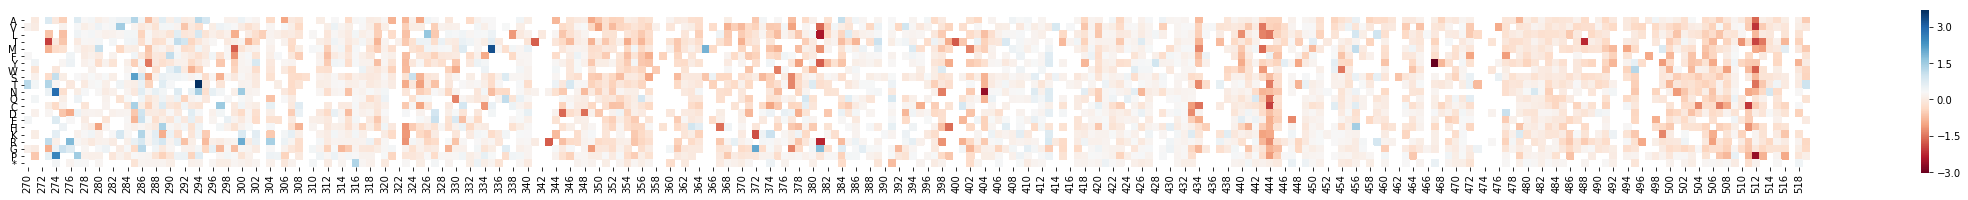

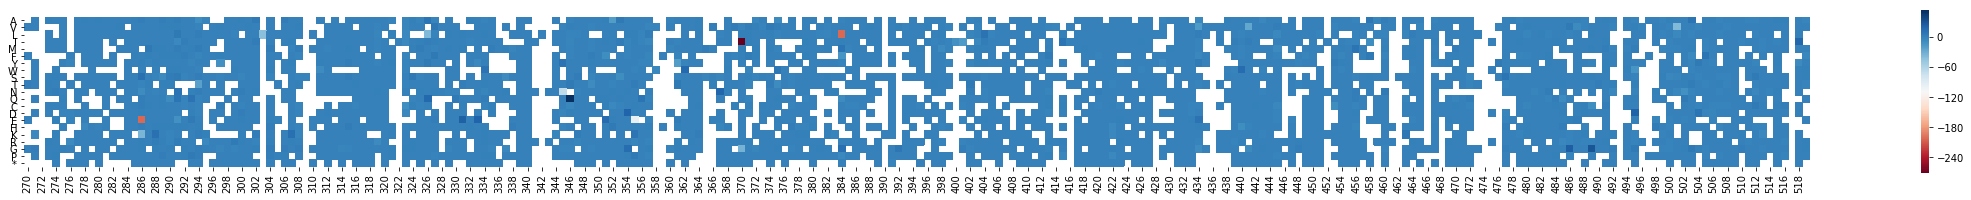

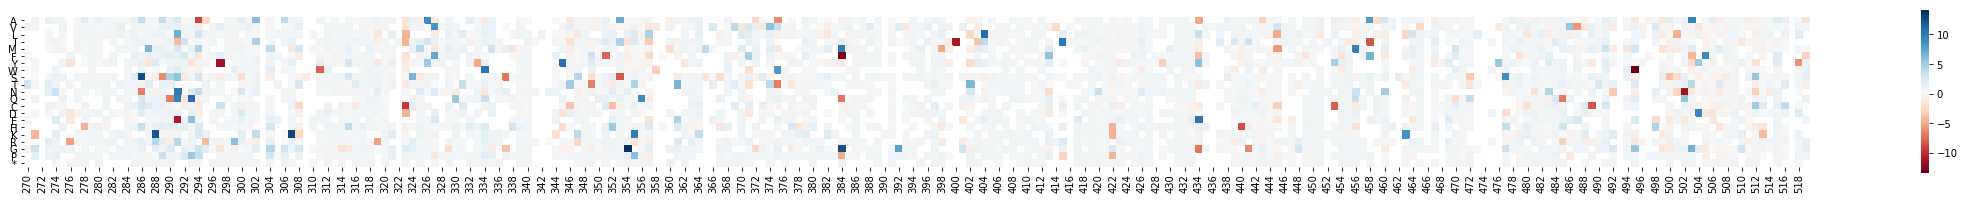

In [131]:
# Plot heatmaps
plt.figure(figsize = (40,10))
sns.heatmap(residHeatMap.astype(float), mask = residHeatMap.isnull(), square = True, cbar_kws = {"shrink": 0.3}, cmap = "RdBu")
plt.show()

plt.figure(figsize = (40, 10))
sns.heatmap(ratioHeatMap.astype(float), mask = ratioHeatMap.isnull(), square = True, cbar_kws = {"shrink" : 0.3}, cmap = "RdBu")
plt.show()

plt.figure(figsize = (40, 10))
sns.heatmap(ratioTrimHeatMp.astype(float), mask = ratioTrimHeatMp.isnull(), square = True, cbar_kws = {"shrink" : 0.3}, cmap = "RdBu")
plt.show()

In [127]:
ratioHeatMap

,270,271,272,273,274,275,276,277,278,279,...,510,511,512,513,514,515,516,517,518,519
A,NaN,0.660166,NaN,1.36632,0.815392,0.674895,NaN,0.218625,2.19362,0.609592,...,0.787541,-0.559854,-0.140491,0.55699,0.654153,2.07552,1.39714,NaN,0.527362,-1.80324
V,0.947734,0.542831,NaN,NaN,NaN,0.914244,NaN,0.610155,0.688079,0.66041,...,0.498242,0.167401,-0.0240283,-0.0484981,0.441883,0.664731,0.304354,NaN,0.685093,0.810847
L,NaN,NaN,NaN,0.339169,NaN,-0.0638126,NaN,0.586423,0.55427,0.6066,...,0.522852,NaN,-0.45522,0.68309,0.750863,NaN,1.18089,NaN,1.67462,NaN
I,NaN,NaN,NaN,-0.0122796,0.839158,0.423564,NaN,0.780107,0.586699,0.654971,...,-1.11035,0.438109,0.0414729,-0.295985,0.483803,-0.164549,0.507295,NaN,20.1941,NaN
M,NaN,NaN,NaN,0.344452,0.660864,0.667062,NaN,0.667709,0.495125,0.754849,...,NaN,NaN,0.261711,-0.493066,0.604041,0.712767,0.374803,NaN,0.793529,0.0600074
F,0.555432,NaN,NaN,NaN,NaN,NaN,1.05231,NaN,0.515496,0.708893,...,NaN,0.446496,NaN,0.563533,NaN,2.04636,NaN,NaN,NaN,-2.86501
Y,NaN,0.186175,NaN,NaN,NaN,0.944096,-1.5698,NaN,0.494718,0.673201,...,1.03944,0.395236,-1.91878,NaN,NaN,1.9267,NaN,NaN,-5.84857,1.13535
W,NaN,0.666067,NaN,NaN,0.81337,NaN,NaN,NaN,NaN,0.703815,...,NaN,0.35263,0.462671,0.440196,NaN,0.716548,NaN,NaN,0.849136,1.40354
S,NaN,0.333642,NaN,0.746235,1.20712,1.00195,NaN,0.613678,0.142272,0.629736,...,NaN,0.959454,5.60586,0.503448,0.541003,0.804054,0.0566591,NaN,0.670166,1.60785
T,2.97015,0.570121,NaN,1.67446,1.03191,NaN,0.815002,NaN,0.766697,0.662073,...,NaN,NaN,-0.585944,0.350782,0.817143,0.223322,1.87528,NaN,0.660688,-0.435066


In [73]:
type(residHeatMap.loc['A',271])

numpy.float64